# Loading data and $0^{\text{th}}$ order EDA

In [49]:
# Load the required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [50]:
# Read the raw file
data_path = 'data/original.xlsx'
xls = pd.ExcelFile(data_path)
print(xls.sheet_names)

['Training_set_Staphiloccocus', 'Test_set_Staphiloccocus']


In [51]:
# There are two ('train' + 'test') excel sheets, which we import separately. We'll use both for thraining/validation
# and the test set is provided separately below
df1 = xls.parse('Training_set_Staphiloccocus')
df2 = xls.parse('Test_set_Staphiloccocus')

In [52]:
# merge the two excel sheets into the training/validation data
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                372 non-null    float64
 1   Normalized Hydrophobicity                    372 non-null    float64
 2   Net Charge                                   372 non-null    int64  
 3   Isoelectric Point                            372 non-null    float64
 4   Penetration Depth                            372 non-null    int64  
 5   Tilt Angle                                   372 non-null    int64  
 6   Propensity to Disordering                    372 non-null    float64
 7   Linear Moment                                372 non-null    float64
 8   Propensity to in vitro Aggregation           372 non-null    float64
 9   Angle Subtended by the Hydrophobic Residues  372 non-null    int64  
 10  Am

In [53]:
df.head(5)

,Normalized Hydrophobic Moment,Normalized Hydrophobicity,Net Charge,Isoelectric Point,Penetration Depth,Tilt Angle,Propensity to Disordering,Linear Moment,Propensity to in vitro Aggregation,Angle Subtended by the Hydrophobic Residues,Amphiphilicity Index,Propensity to Coil Conformation,Class
0,0.13086,0.99417,3,14.00000,13,57,-0.14436,0.43929,0.0000,30,2.34417,1.16000,0
1,0.66814,0.48059,-1,3.71000,13,76,0.81057,0.34281,64.7376,140,0.00000,0.85647,0
2,0.30772,1.65667,3,12.41004,30,73,-0.28033,0.28431,0.0000,20,0.49000,1.57667,0
3,0.33290,1.30687,10,14.00000,16,96,-0.62077,0.13325,0.0000,60,1.60688,0.97250,0
4,0.48046,1.17133,5,11.69003,16,116,-0.45079,0.47729,0.0000,30,1.31867,0.99133,0


In [54]:
# df provides the training/validation part of the data. Let us now parse the excel file with the test data.

In [55]:
test_data_path = 'data/additional.xlsx'
test_xls = pd.ExcelFile(test_data_path)
print(test_xls.sheet_names)

['Sheet1', 'Sheet2']


In [56]:
# there is nothing in Sheet2, so we only parse Sheet1

In [57]:
test_df_raw = test_xls.parse('Sheet1')
test_df = test_df_raw.drop(['Sequence'], axis=1)
test_df.head()

,Normalized Hydrophobic Moment,Normalized Hydrophobicity,Net Charge,Isoelectric Point,Penetration Depth,Tilt Angle,Propensity to Disordering,Linear Moment,Propensity to in vitro Aggregation,Angle Subtended by the Hydrophobic Residues,Amphiphilicity Index,Propensity to Coil Conformation,Class
0,0.82061,0.58077,5,14.0,13,88,0.24801,0.27977,0.00000,160,0.94154,0.94385,1
1,0.81958,0.57846,5,14.0,12,83,0.24325,0.25497,0.00000,210,0.94154,0.89538,1
2,0.68071,0.65154,5,14.0,13,82,0.25515,0.27538,3.09227,170,1.13154,0.91077,1
3,0.67621,1.06692,6,14.0,16,114,-0.31450,0.37078,0.00000,70,1.86846,0.96769,1
4,0.43945,0.72385,5,14.0,13,88,0.10519,0.20588,0.00000,80,1.58615,0.96692,1


In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Normalized Hydrophobic Moment                52 non-null     float64
 1   Normalized Hydrophobicity                    52 non-null     float64
 2   Net Charge                                   52 non-null     int64  
 3   Isoelectric Point                            52 non-null     float64
 4   Penetration Depth                            52 non-null     int64  
 5   Tilt Angle                                   52 non-null     int64  
 6   Propensity to Disordering                    52 non-null     float64
 7   Linear Moment                                52 non-null     float64
 8   Propensity to in vitro Aggregation           52 non-null     float64
 9   Angle Subtended by the Hydrophobic Residues  52 non-null     int64  
 10  Amph

In [59]:
# check that the train/valid data and the test data are of the same format

In [60]:
np.sum(df.columns != test_df.columns)

0

### $\color{red}{\textbf{Correlations bewteen features}}$

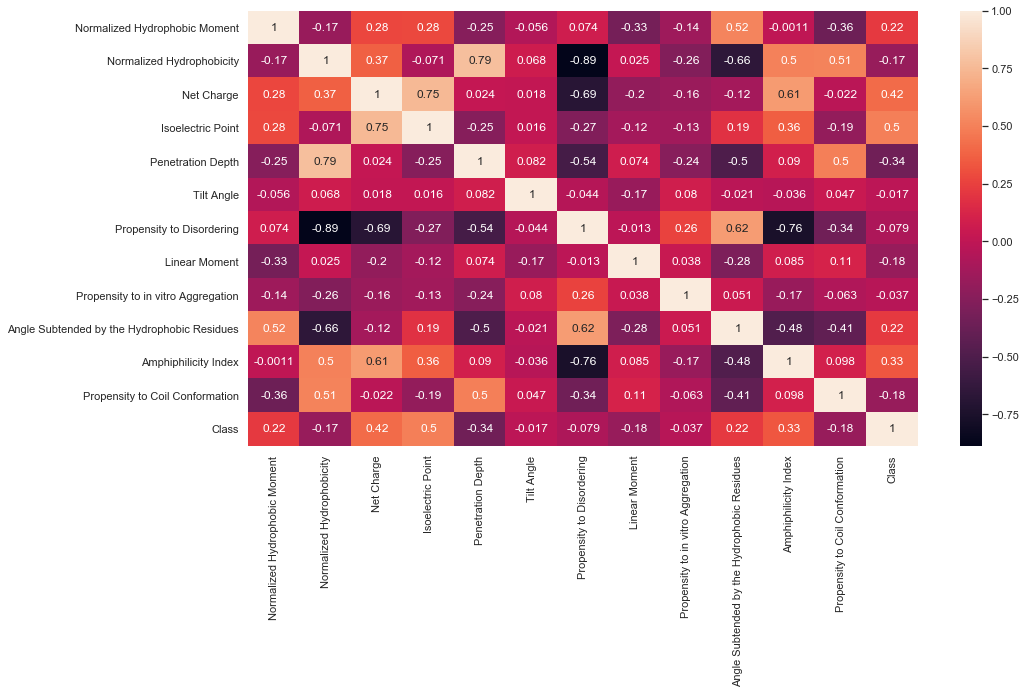

In [61]:
# Correlation matrix 
plt.figure(figsize=(15,8))
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True)

In [62]:
# The strongest correlation is between 'Propensity to Disordering' and 'Normalized Hydrophobicity'
unwrapped = np.abs(corr_mat.values.reshape((1,-1)))
max_abs_cor = unwrapped[unwrapped < 1].max()
print(max_abs_cor)

0.8869020169632253


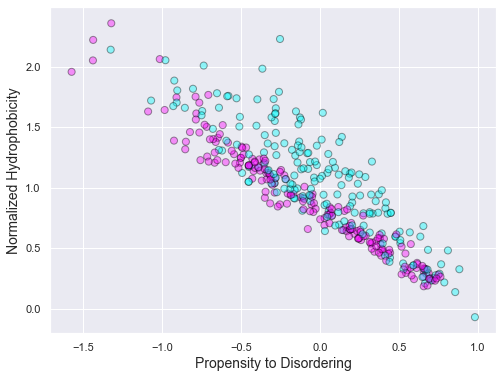

In [63]:
# Let us plot these two features
plt.scatter(df['Propensity to Disordering'], df['Normalized Hydrophobicity'], c=df['Class'], marker='o', 
            s=50, alpha=.4, cmap='cool', edgecolor='black')
plt.xlabel('Propensity to Disordering', fontsize = 14)
plt.ylabel('Normalized Hydrophobicity', fontsize = 14)
plt.show()

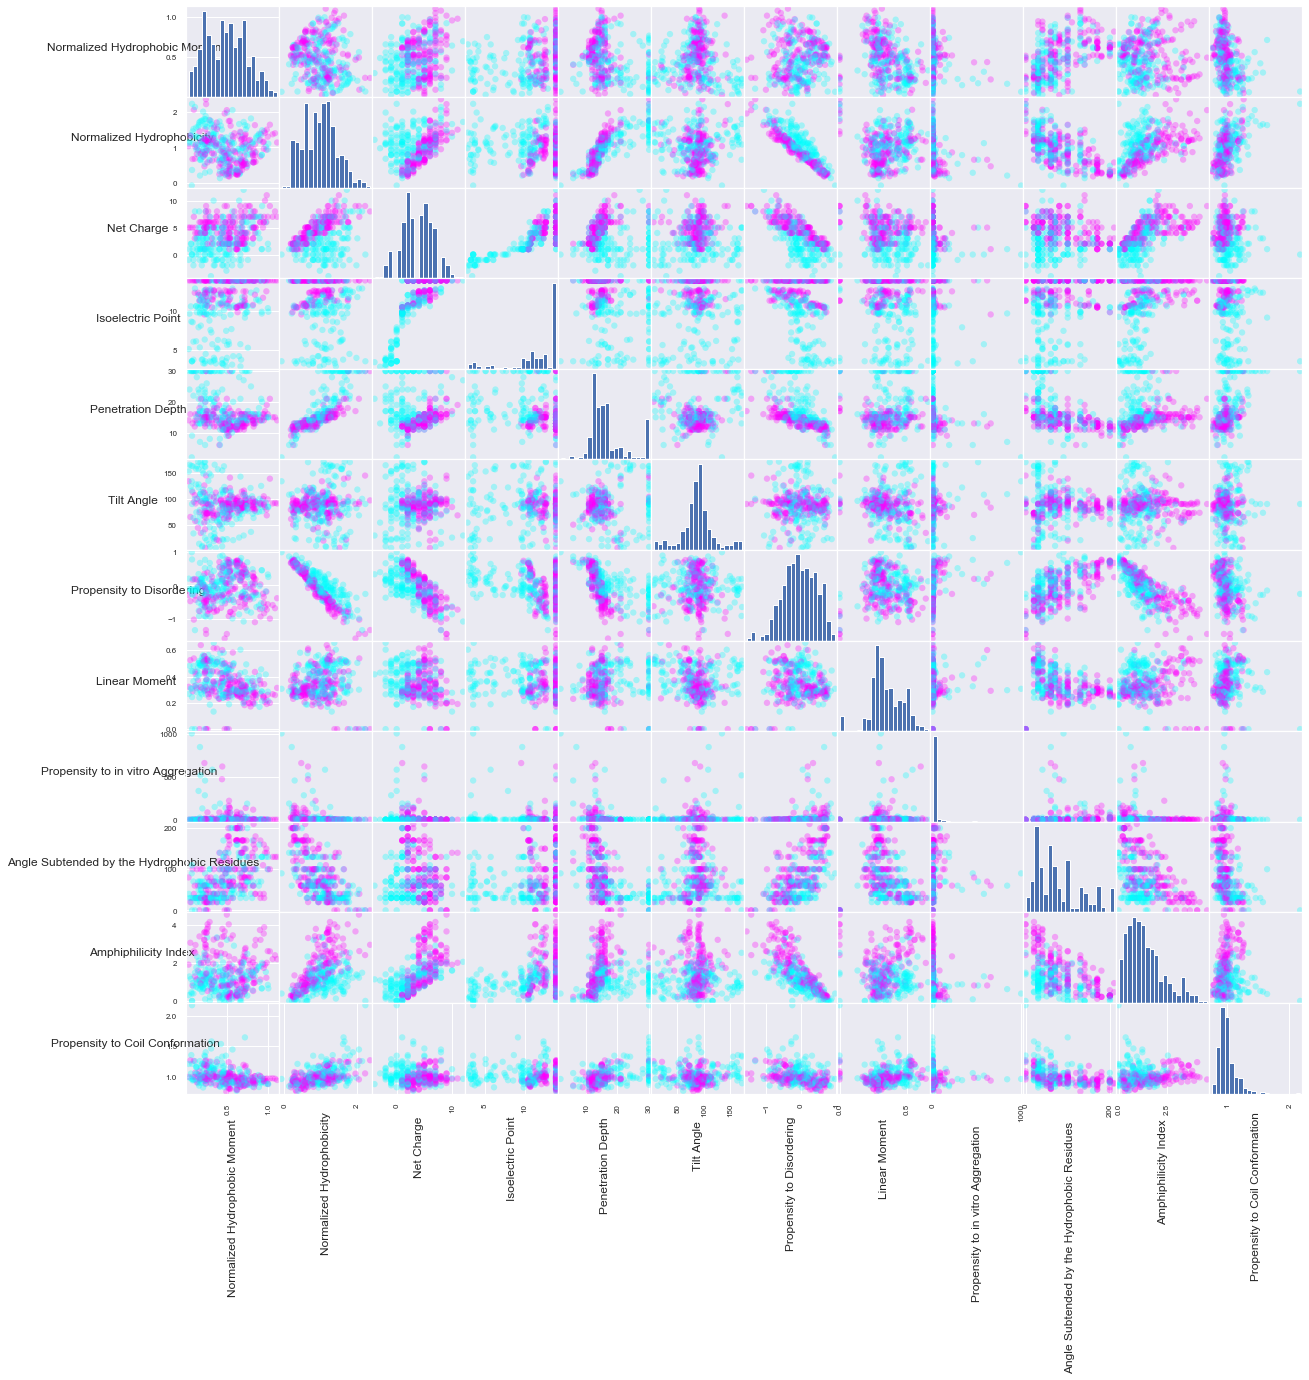

In [64]:
# Plot the full scatter matrix
data_sm = pd.plotting.scatter_matrix(df.drop(['Class'],axis=1),c=df['Class'], figsize=(20, 20), marker='o',
                            hist_kwds={'bins': 20}, s=40, alpha=.3, cmap='cool')
n = len(df.drop(['Class'],axis=1).columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = data_sm[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 30

### $\color{red}{\textbf{PCA}}$

In [65]:
# Let's check if one can reduce dimensionality. For PCA to make sense, standardize data!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

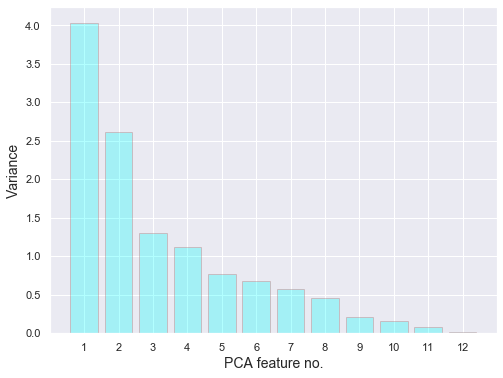

In [66]:
pca_transformer = PCA()
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.bar(features, pca_transformer.explained_variance_, color='cyan', edgecolor='r', alpha=0.3)
plt.xticks(features)
plt.xlabel('PCA feature no.', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.show()

In [67]:
# The data is NOT lower-dimensional, but let's anyway check if the 2-component PCA would separate classes

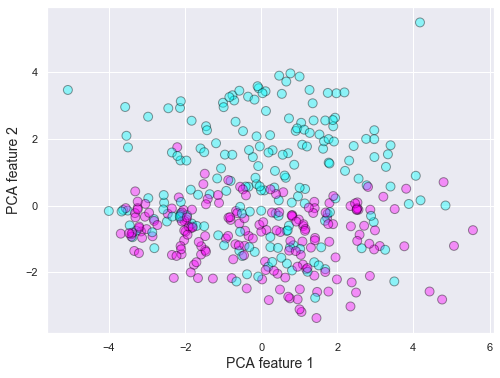

In [68]:
pca_transformer = PCA(n_components=2)
stdzed_raw_data = StandardScaler().fit_transform(df.drop(['Class'], axis=1).values)
pca_transformer.fit(stdzed_raw_data)
pca_feat_matrix = pca_transformer.transform(stdzed_raw_data)
features = range(1, pca_transformer.n_components_ + 1)
plt.scatter(pca_feat_matrix[:,0], pca_feat_matrix[:,1], c=df['Class'], marker='o', 
            s=80, alpha=.4, cmap='cool', edgecolor='black')
plt.xlabel('PCA feature 1', fontsize=14)
plt.ylabel('PCA feature 2', fontsize =14)
plt.show()

In [69]:
# Not really. Let's move on.

# Fitting and predicting

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [71]:
# split into features and labels (and transform to np arrays)
X = df.drop(['Class'], axis=1).values
y = df['Class'].values
print(X.shape, y.shape)

(372, 12) (372,)


In [72]:
X_test = test_df.drop(['Class'], axis=1).values
y_test = test_df['Class'].values
print(X_test.shape, y_test.shape)

(52, 12) (52,)


### $\color{red}{\textbf{SVM}}$

#### In this first version, we will not touch the $\gamma$ parameter and change kernel; 'rbf' seems to work best

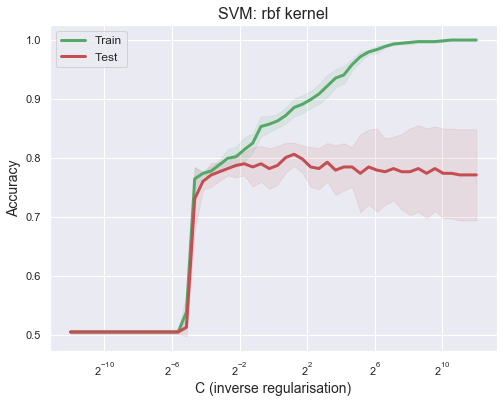

In [73]:
def SVMPredict(kernel, C, X, y):
    clf = make_pipeline(StandardScaler(), svm.SVC(kernel=kernel, C=C))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

######### CHOOSE ADDITIONAL PARAMETERS HERE

kernel = 'rbf' 

######### CHOOSE ADDITIONAL PARAMETERS HERE

C_list = np.logspace(-12, 12, base = 2.)
train_accuracies = np.asarray([SVMPredict(kernel, C, X, y)['train_mean'] for C in C_list])
train_stds = np.asarray([SVMPredict(kernel, C, X, y)['train_std'] for C in C_list])
plt.plot(C_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(C_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([SVMPredict(kernel, C, X, y)['test_mean'] for C in C_list])
test_stds = np.asarray([SVMPredict(kernel, C, X, y)['test_std'] for C in C_list])
plt.plot(C_list, test_accuracies, 'r', linewidth = 3)
plt.xscale('log', basex=2)
plt.fill_between(C_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('SVM: rbf kernel', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('C (inverse regularisation)', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [74]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = svm.SVC(kernel=kernel, C=1000)
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846

### $\color{red}{\textbf{k nearest neighbours}}$

#### Accuracy vs k for uniform and dustance kNN

In [75]:
# define a function that performs CV together with normalisation of data and plots accuracy vs k

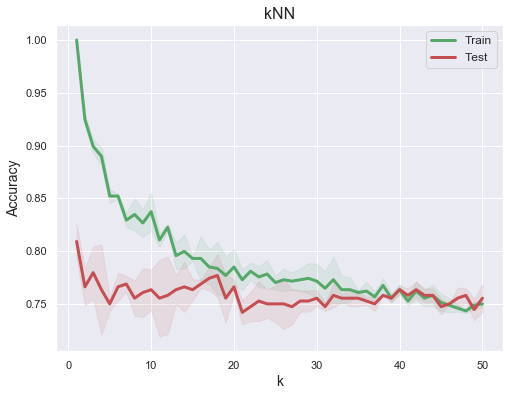

In [76]:
def kNNpredict_uniform(k, X, y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

k_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([kNNpredict_uniform(k, X, y)['train_mean'] for k in k_list])
train_stds = np.asarray([kNNpredict_uniform(k, X, y)['train_std'] for k in k_list])
plt.plot(k_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(k_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([kNNpredict_uniform(k, X, y)['test_mean'] for k in k_list])
test_stds = np.asarray([kNNpredict_uniform(k, X, y)['test_std'] for k in k_list])
plt.plot(k_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(k_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('kNN', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [77]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = KNeighborsClassifier(n_neighbors=8, weights='uniform')
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6538461538461539

### $\color{red}{\textbf{Decision trees}}$

In [78]:
# Trees do not generally require standardisation of data, so we will no include the latter

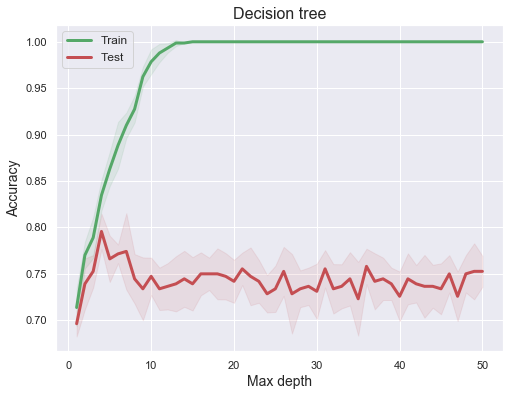

In [79]:
def TreePredict(depth, X, y):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

depth_list = np.asarray([*range(1, 51)])
train_accuracies = np.asarray([TreePredict(depth, X, y)['train_mean'] for depth in depth_list])
train_stds = np.asarray([TreePredict(depth, X, y)['train_std'] for depth in depth_list])
plt.plot(depth_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(depth_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([TreePredict(depth, X, y)['test_mean'] for depth in depth_list])
test_stds = np.asarray([TreePredict(depth, X, y)['test_std'] for depth in depth_list])
plt.plot(depth_list, test_accuracies, 'r', linewidth = 3)
plt.fill_between(depth_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Decision tree', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Max depth', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [80]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846

### $\color{red}{\textbf{Logistic regression}}$


In [81]:
# Let us try logreg both with and without data standardization. First standardise

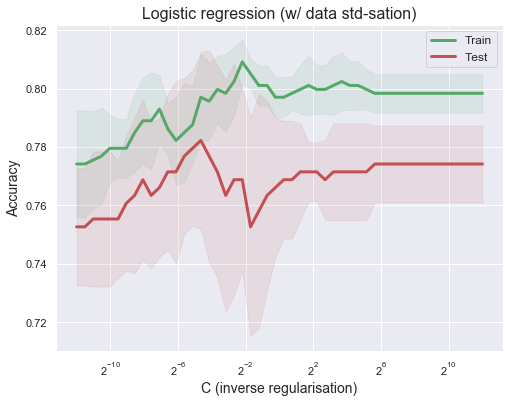

In [82]:
def LogRegPredict(C, X, y):
    clf = make_pipeline(StandardScaler(), LogisticRegression(C=C, solver='liblinear'))
    scores = cross_validate(clf, X, y, cv=3, return_train_score=True)
    return {'test_mean': scores['test_score'].mean(), 'test_std': scores['test_score'].std(), 
            'train_mean': scores['train_score'].mean(), 'train_std': scores['train_score'].std()}

C_list = np.logspace(-12, 12, base = 2.)
train_accuracies = np.asarray([LogRegPredict(C, X, y)['train_mean'] for C in C_list])
train_stds = np.asarray([LogRegPredict(C, X, y)['train_std'] for C in C_list])
plt.plot(C_list, train_accuracies, 'g', linewidth = 3)
plt.fill_between(C_list, train_accuracies - train_stds, train_accuracies + train_stds, alpha = 0.10, color='g')
test_accuracies = np.asarray([LogRegPredict(C, X, y)['test_mean'] for C in C_list])
test_stds = np.asarray([LogRegPredict(C, X, y)['test_std'] for C in C_list])
plt.plot(C_list, test_accuracies, 'r', linewidth = 3)
plt.xscale('log', basex=2)
plt.fill_between(C_list, test_accuracies - test_stds, test_accuracies + test_stds, alpha = 0.10, color='r')
plt.legend(('Train', 'Test'), fontsize = 12)
plt.title('Logistic regression (w/ data std-sation)', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('C (inverse regularisation)', fontsize = 14)
plt.show()

#### Calculate the test accuracy

In [84]:
# standardizing data (both train+valid and test)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# standardizing data (both train+valid and test)
clf = LogisticRegression(C=1, solver='liblinear')
clf.fit(X_scaled, y)
y_test_pred = clf.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.6346153846153846